# TP 1: Parcours des protons dans la matière

In [1]:
import numpy as np
import scipy as sp
#import graphinglib as gl
import matplotlib.pyplot as plt

from scipy.constants import N_A, c, m_e, m_p, e

In [2]:
# Définition de fonctions et classes utiles

def densite_electronique(matiere, rho):
    n_e = 0
    for x in matiere:
        n_e += x[0]*x[1]/x[2]
    return rho*n_e*N_A

## Questions:

### 1- Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

La cellule suivante donne les numéros atomiques, la fraction massique et la masse molaire des éléments composant l'eau et l'os compact, de même que la masse volumique de ces deux substances. La fonction densite_electronique reçoit en argument la composition chimique d'une matière et sa masse volumique en g/cm $^3$ et retourne sa densité électronique en électrons par cm $^3$.

In [3]:
# Numéros atomiques, composition atomique et masse molaire
eau = [(1, 0.111894, 1.008), (8, 0.888106, 15.999)]
os_compact = [(1, 0.063984, 1.008), (6, 0.278000, 12.011), (7, 0.027000, 14.007), (8, 0.410016, 15.999),
              (12, 0.002000, 24.305), (15, 0.070000, 30.974), (16, 0.002000, 32.06), (20, 0.147000, 40.078)]

# Masses volumiques en g/cm^3
rho_eau = 1.00000
rho_os_compact = 1.85000

# Densités électroniques en électrons/cm^3
n_eau = densite_electronique(eau, rho_eau)
n_os_compact = densite_electronique(os_compact, rho_os_compact)

### 2- Tracez les courbes du pouvoir d’arrêt collisionnel massique pour ces milieux en fonction de l’énergie cinétique (T). Pour expliciter la dépendance en T de $S_{col}$, utilisez les relations 9 et 10 ci-bas. Pour le graphique, utilisez une échelle logarithmique en abscisse. Vous trouverez les énergies moyennes d’excitation I de ces matériaux sur le site du NIST également.

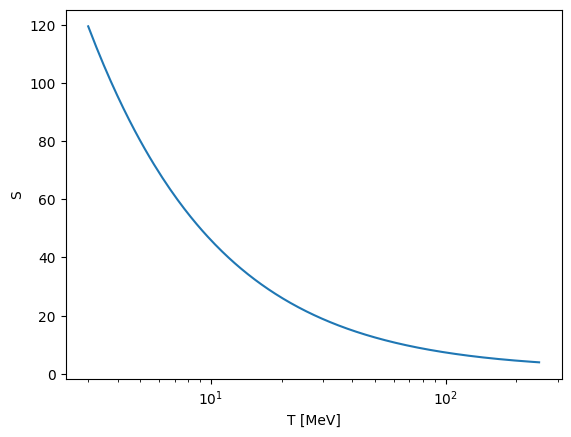

In [4]:
# Constantes importantes
mp = m_p/(10**6*e) # En MeV/c^2
me = m_e/(10**6*e) # En MeV/c^2
r_e = 10**2*sp.constants.value('classical electron radius') # En cm

# Énergies d'excitation en MeV
I_eau = 75.000000*10**(-6)
I_os_compact = 91.900000*10**(-6)

# Quantités importantes
T = np.linspace(3, 250, 1000) # En MeV
gamma = T/(mp*c**2)+1
beta = ((gamma**2-1)/gamma**2)**0.5
a = 2*me*c**2
b = 1+(me/mp)**2
delta = 2*me/mp
Tmax = a*(gamma**2-1)/(b+delta*gamma)

def pouvoir_collisionnel_massique(n_e, I, rho):
    U = np.pi*r_e**2*a*n_e
    k = a/I**2
    S = (U/(beta**2*rho))*(np.log(k*beta**2*gamma**2*Tmax)-2*beta**2)
    plt.plot(T, S)
    plt.xlabel('T [MeV]')
    plt.ylabel('S')
    plt.xscale('log')
    plt.show()

pouvoir_collisionnel_massique(n_eau, I_eau, rho_eau)